In [0]:
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import math

from pandas import Series
from statistics import mean
from statistics import median
from math import sqrt

from matplotlib import pyplot

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

import plotly as py
import plotly.graph_objects as go

#!pip install fbprophet
from fbprophet import Prophet

!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima

pd.plotting.register_matplotlib_converters() # was getting error plotting series until entering this..

     |████████████████████████████████| 1.5MB 4.6MB/s 


Import data

In [0]:
# zillow
homes = pd.read_csv('https://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv', encoding='latin_1')

In [0]:
homes.shape # (30434, 292)
len(homes['RegionName'].unique()) # 30,434 zip codes, one for each row.

30434

Arkansas Metro area analysis

In [0]:
ar_homes = homes[homes.State=='AR']

df = pd.DataFrame()
def getMetroAvg(cityName, col):
  global df
  city_homes = ar_homes.loc[ar_homes.City==cityName, col]
  avg = mean(city_homes[~np.isnan( city_homes)])
  df = df.append({'Date':date, 'Avg':avg, 'City':cityName}, ignore_index=True )

for col in ar_homes.columns: 
    date = pd.to_datetime(col, format='%Y-%m', errors='coerce')
    if(date >= pd.to_datetime('01-01-1997')):
      # get metro averages
      getMetroAvg('Hot Springs', col)  
      getMetroAvg('Little Rock', col)  
      getMetroAvg('Fayetteville', col)  
      getMetroAvg('Searcy', col)  

df = df.set_index('Date')

hotSprings_homes = df[df['City']=='Hot Springs']
littleRock_homes = df[df['City']=='Little Rock']
fayetteville_homes = df[df['City']=='Fayetteville']
searcy_homes = df[df['City']=='Searcy']

# Plot results
fig = go.Figure()
fig.add_trace(go.Scatter(x=hotSprings_homes.index, y=hotSprings_homes.Avg, name='Hot Springs',
                          line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=littleRock_homes.index, y=littleRock_homes.Avg, name='Little Rock',
                          line_color='red'))
fig.add_trace(go.Scatter(x=fayetteville_homes.index, y=fayetteville_homes.Avg, name='Fayetteville',
                          line_color='gray'))
fig.add_trace(go.Scatter(x=searcy_homes.index, y=searcy_homes.Avg, name='Searcy',
                          line_color='#0028FF'))
fig.update_layout(title_text='Average Home Sales in Arkansas Metro Areas',
                  xaxis_rangeslider_visible=False)
fig.show()

Predicting avg median housing value by zip code in 2018

In [0]:
# Transpose and make series
def getSeries(df):

  df = df.transpose()

  # row names
  df.insert(0, 'Date', df.index.values)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m', errors='coerce')

  # col names
  zips = df.iloc[1]
  cols = ['zip_{0}'.format(z) for z in zips]
  cols[0] = 'Date'
  df.columns = cols

  # drop additional info
  df = df.drop('RegionID')
  df = df.drop('City')
  df = df.drop('State')
  df = df.drop('Metro')
  df = df.drop('CountyName')
  df = df.drop('RegionName')
  df = df.drop('SizeRank')

  # make time series
  df = df.set_index('Date')

  # create avg column
  df['zip_median'] = df.median(axis=1)

  # backwards fill for nan values
  df = df.fillna(method='bfill')
  #homes = homes.fillna(method='ffill')

  return df

In [0]:
all_homes = getSeries(homes)
syr_homes = getSeries(homes[(homes.City=='Syracuse') & (homes.State=='NY')])

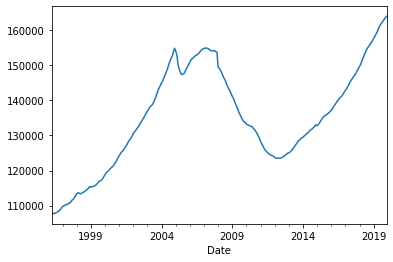

In [0]:
# Is stationary? Visualize. 
all_homes['zip_median'].plot() # Dont see seasonality.

Calculate Returns

In [0]:
# function to calculate gain percentage (ROI) on previous 2, 5 and 10 years
# source: https://github.com/gioamorim80/Zillow-Time-Series/blob/master/Module%204%20Final%20Project.ipynb
def calculate_gain(ts, plot=True): 
    
    '''Takes a real estate time series and performs calculations on returns over investments
    for periods of 2 and 5 years.'''
    
    # calculates ROI by taking current value, decreasing investment(value at x steps in past) and 
    # dividing by investment. Multiplies by 100 to get percentage number
    roi_2 = (ts - ts.shift(periods=24))/ts.shift(periods=24)*100
    roi_5 = (ts - ts.shift(periods=60))/ts.shift(periods=60)*100
    roi_10 = (ts - ts.shift(periods=120))/ts.shift(periods=120)*100
    roi_2.dropna(inplace=True)
    roi_5.dropna(inplace=True)
    roi_10.dropna(inplace=True)
    
    # plot results
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=roi_2.index, y=roi_2.value, name='2-Year Investment',
                                 line_color='deepskyblue'))
        fig.add_trace(go.Scatter(x=roi_5.index, y=roi_5.value, name='5-Year Investment',
                                 line_color='red'))
        fig.add_trace(go.Scatter(x=roi_10.index, y=roi_10.value, name='10-Year Investment',
                                 line_color='gray'))
        fig.update_layout(title_text='Mean Zillow Home Value Index (ZHVI) - ROI Over Time Invested',
                          yaxis_title="ROI (%)", 
                          xaxis_rangeslider_visible=False)
        fig.show()
    
    # saves new ts with returns for 2, 5 and 10 periods
    return roi_2, roi_5, roi_10

In [0]:
'''
# convert df's to ROI
zip_median_df = pd.DataFrame(data = all_homes['zip_median'].values, index = all_homes['zip_median'].index, columns=['value'])
zip_median_roi2, zip_median_roi5, zip_median_roi10 = calculate_gain(zip_median_df)
'''

In [0]:
def stationaryTest(df):
  X = df.value
  X = X.astype('float32')

  # Is stationary? Run AD FUller, p-value < .05 ?
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

  # LOOK FOR ACF & PACF
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
  fig = plot_acf(X, lags=40, ax=ax1)
  ax1.axhline(y=0,linestyle='--',color= 'gray')
  ax1.axhline(y= - 1.96/np.sqrt(len(df)), linestyle='--',color= 'gray')
  ax1.axhline(y=  1.96/np.sqrt(len(df)), linestyle='--',color= 'gray')
  ax1.set_label('Lags')

  fig = plot_pacf(X, lags=40, ax=ax2)
  ax2.axhline(y=0,linestyle = '--', color = 'gray')
  ax2.axhline(y = -1.96/np.sqrt(len(df)), linestyle = '--', color = 'gray')
  ax2.axhline(y = 1.96/np.sqrt(len(df)), linestyle = '--', color = 'gray')
  ax2.set_label('Lags')




ADF Statistic: -1.089803
p-value: 0.719121


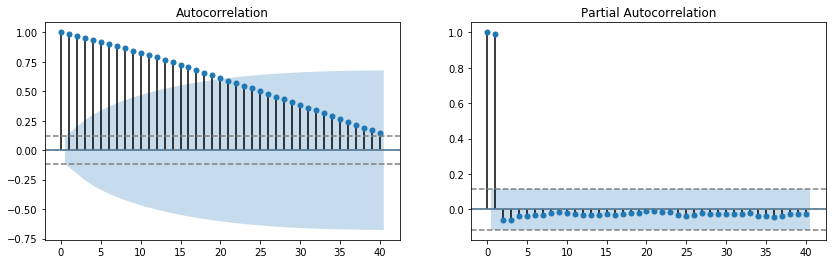

In [0]:
df = pd.DataFrame(data=all_homes['zip_median'].values, index=all_homes.index, columns=['value'])
stationaryTest(df) # p-value: 0.719121

In [0]:
'''
# Get fuller p-values for different lags

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# Make stationary
X = zip_median_roi5.value
X = X.astype('float32')

# difference data

for p in range(0, 40):
  lags = p
  stationary = difference(X, lags)
  result = adfuller(stationary)
  if result[1] < .05:
    print('lags: ' + str(p) + ', p-value: ' + str(result[1]))

#lags: 1, p-value: 0.016
'''

In [0]:
'''
# make stationary with lag = 1, as discovered to be best with AD Fuller test
lags = 1
stationary = difference(X, lags)
stationary.index = df.index[lags:]

# USING STATIONARY TIME SERIES LOOK FOR ACF & PACF
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
fig = plot_acf(stationary, ax=ax1)
ax1.axhline(y=0,linestyle='--',color= 'gray')
ax1.axhline(y= - 1.96/np.sqrt(len(stationary)), linestyle='--',color= 'gray')
ax1.axhline(y=  1.96/np.sqrt(len(stationary)), linestyle='--',color= 'gray')
ax1.set_label('Lags')

fig = plot_pacf(stationary, ax=ax2)
ax2.axhline(y=0,linestyle = '--', color = 'gray')
ax2.axhline(y = -1.96/np.sqrt(len(stationary)), linestyle = '--', color = 'gray')
ax2.axhline(y = 1.96/np.sqrt(len(stationary)), linestyle = '--', color = 'gray')
ax2.set_label('Lags')
'''

In [0]:
'''
# BEST ARIMA params
# CODE RUNS LONG FOR EVALUATION - approximately 
import warnings

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.70)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		lags = 1 # best value discovered with fuller test above
		diff = difference(history, lags)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, lags)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

warnings.filterwarnings("ignore")
evaluate_models(df['zip_median'].values, p_values, d_values, q_values)

# Best: ARIMA(6, 1, 0) RMSE=139.733
'''

In [0]:
# define a function to run auto arima and search for best model parameters
def find_orders(ts):
    
    '''Takes a time series and finds the best differencing order, as well as the other best
    parameters for a SARIMAX model using auto_arima'''
    
    stepwise_model = pm.auto_arima(ts, start_p=1, start_q=1, max_p=4, max_q=14,
                                #exogenous=exog, 
                                m=12, seasonal=True, stationary=False,
                                stepwise=True, trend='ct',
                                suppress_warnings=True, trace=False, 
                                error_action='ignore')
   
    return stepwise_model.order, stepwise_model.seasonal_order

In [0]:
def fit_sarimax_model(ts, exog, order=(1,1,1), seasonal_order=(0, 0, 0, 12), summary=True, plot=True):
    
    '''Takes a time series and runs a SARIMAX model with parameter order provided. 
    If no parameter provided default is (1,1,1), (0,0,0,12). 
    Has the default option to print model summary and plot diagnostics, which can be turned off'''
  
    # fit model
    model = sm.tsa.statespace.SARIMAX(ts, 
                                    exog = exog,  
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    trend='ct',
                                    enforce_stationarity=True,
                                    enforce_invertibility=False)
    

    output = model.fit(d=0)
    
    if summary==True:
        print(output.summary())

    if plot==True:
        # plot model diagnostics
        output.plot_diagnostics(figsize=(15, 18))
        plt.show()
        
    return output

In [0]:
# find best arima/sarimax params, without exog's
df = pd.DataFrame(data=all_homes['zip_median'].values, index=all_homes.index, columns=['value'])
find_orders(df) # ((0, 2, 1), (0, 0, 0, 12))

((0, 2, 1), (0, 0, 0, 12))

Dept of Labor Employment Dataset

In [0]:
# DOL Employment
# https://beta.bls.gov/dataViewer/view/timeseries/CES0000000001;jsessionid=542AB1B7EFC43613AD715045DF37B0B6
employ = pd.read_csv('https://github.com/vksyr/IST718/raw/master/DOL_empl.csv')
employ = employ[3:]  # remove first 3 months not in the main housing dataset
employ = pd.DataFrame(data=employ['Value'].values, index=zip_median_df.index, columns=['value'])

In [0]:
exog = pd.DataFrame(data=employ.values, index=employ.index, columns=['value'])

for index, row in exog.iterrows():
  idx = employ.index.get_loc(index) + 4
  if idx < len(employ):
    nextIdx = employ.index[idx]
    exog.loc[str(index)[:7]].value = employ[str(nextIdx)[:7]].value[0]

#### 2-year ROI - employment exog test ####
# exog,     p-value = 0.241 :(
# exog n+1, p-value = 0.171 :(
# exog n+2, p-value = 0.156 :(
# exog n+3, p-value = 0.381 :(
# exog n+4, p-value = 0.042 :)
# exog n+5, p-value = 0.807 :(
# exog n+6, p-value = 0.777 :(
# exog n+7, p-value = 0.540 :(
    
#### 5-year ROI - employment exog test ####
# exog,     p-value = 0.464 :(
# exog n+1, p-value = 0.620 :(
# exog n+2, p-value = 0.328 :(
# exog n+3, p-value = 0.485 :(
# exog n+4, p-value = 0.231 :(
# exog n+5, p-value = 0.287 :(
# exog n+6, p-value = 0.739 :(
# exog n+7, p-value = 0.194 :(

In [0]:

#exog_lag1 = pd.DataFrame(data = arr[0:len(employ)], index=employ.index)
exog = exog[len(exog) - len(zip_median_roi2):] 

# find best params, takes a long time
#find_orders(zip_median_roi2, exog) # ((2, 1, 0), (0, 0, 0, 12))
zip_median_roi2_output = fit_sarimax_model(zip_median_roi2, exog=exog, order=(2, 1, 0), seasonal_order=(0, 0, 0, 12), plot=False) #  employ p-value: 0.241 :(

#find_orders(zip_median_roi5, exog) # ((1, 2, 0), (0, 0, 0, 12))
#zip_median_roi5_output = fit_sarimax_model(zip_median_roi5, exog=exog, order=(1, 2, 0), seasonal_order=(0, 0, 0, 12), plot=False) # employ p-value: 0.464 :(

#find_orders(zip_median_roi5, exog) # ((0, 2, 1), (0, 0, 0, 12))    
#zip_median_roi10_output = fit_sarimax_model(zip_median_roi10, exog=exog, order=(0, 2, 1), seasonal_order=(0, 0, 0, 12), plot=False) # employ p-value: 0.547 :(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  261
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 -92.409
Date:                Thu, 13 Feb 2020   AIC                            196.817
Time:                        15:36:50   BIC                            218.181
Sample:                    04-01-1998   HQIC                           205.406
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0290      0.068     -0.426      0.670      -0.162       0.104
drift          0.0002      0.001      0.324      0.746      -0.001       0.001
value          0.0003      0.000      2.037      0.0

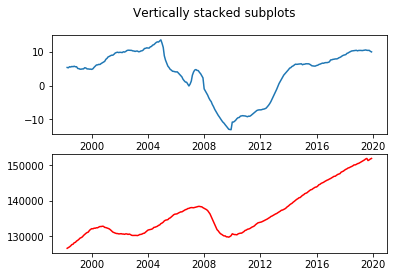

In [0]:
# visualize roi with employment

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(zip_median_roi2)
axs[1].plot(employ[len(employ) - len(zip_median_roi2):], color='red')

# maybe 2 lags off?

In [0]:
zip_median_roi5

Make predictions

In [0]:
'''
# get training data (1997-2017) and test data (2018)

homes_before2018 = df['zip_median'].loc[:'2017']
homes_2018 = df['zip_median'].loc['2018']
train = homes_before2018.values.astype('float32')
test = homes_2018.values.astype('float32')

history = [x for x in train]

#cutoff = round(X.size * .8)
#train = X[:cutoff]
#test = X[cutoff+1:]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# make predictions
predictions = list()

for i in range(len(test)):
	
	lags = 1
	diff = difference(history, lags) 	# difference data
	model = ARIMA(diff, order=(6,1,0)) # best p,d, & q values discovered from the loop above
	model_fit = model.fit(trend='nc', disp=0)

	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, lags)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	#print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
	'''

In [0]:
'''
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
'''

In [0]:
'''
# residuals
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
residuals.hist(ax=pyplot.gca())
pyplot.show()

# mean: -11.894349
'''

In [0]:
'''
# Make new predictions with mean residual as bias
bias = -11.894349
predictions = list()

for i in range(len(test)):
	
	lags = 1
	diff = difference(history, lags) 	# difference data
	model = ARIMA(diff, order=(6,1,0)) # best p,d, & q values discovered from the loop above
	model_fit = model.fit(trend='nc', disp=0)

	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, lags)

	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	#print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
	'''

In [0]:
'''
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


# not as good
'''

In [0]:
'''
# merge employment data to main df
df['Natl_empl'] = list(employ['Value'])
'''

In [0]:
'''
# SARIMAX Model

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# test/training data
train = df.loc[:'2017']
test = df.loc['2018']  

history = [x for x in train['zip_median']]

# make predictions
predictions = list()
lags = 1

for i in range(len(test)):

  # make new series to make new model.
  diff_series = pd.DataFrame()
  diff_series['zip_median_diff'] = difference(history, lags) # difference data
  diff_series.index = df[1:len(diff_series)+1].index

  # make new model
  model = sm.tsa.statespace.SARIMAX(endog = diff_series['zip_median_diff'],
    exog = df['Natl_empl'][1:len(history)],  
    trend='t',  # ‘n’,’c’,’t’, or ’ct’
    order=(6,1,0)
  )
  
  model_fit = model.fit()

  # predict and then add single prediction to history
  yhat = model_fit.predict(start = pd.to_datetime('2018-01'), end = pd.to_datetime('2018-12'),
    exog = pd.DataFrame(test['Natl_empl'][i:]), 
    dynamic= True)[i]

  yhat = inverse_difference(history, yhat, lags)

  predictions.append(yhat)
  # observation
  obs = test['zip_median'].iloc[i]

  history.append(obs)
  # should we be saving the test obs or predicted obs to train the model for
  # the next prediction
  '''

In [0]:
'''
# report performance
mse = mean_squared_error(test['zip_median'].values, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# SARIMAX (6, 1, 0), trend = 'n', w/ exog  --> RMSE: 192.517
# SARIMAX (6, 1, 0), trend = 'c', w/ exog  --> RMSE: 192.517
# SARIMAX (6, 1, 0), trend = 'ct', w/ exog --> RMSE: 193.963
# SARIMAX (6, 1, 0), trend = 't', w/ exog  --> RMSE: 188.584, no exog: RMSE: 188.673

# plot
pyplot.plot(test['zip_median'].values)
pyplot.plot(predictions, color='red')
pyplot.show()
'''

In [0]:
def get_predictions(ts, model_output, steps=24, plot=True, show=True):
    
    '''Gets one-step-ahead forecast for model, 
    calculates Root of Mean Squared Error, 
    makes future predictions for number
    of steps passed as parameter(default is 24), 
    plots results, 
    provides last forecasted value with confidence interval'''

    
    # get preditions from model for data period
    pred = model_output.get_prediction(start='2018-01-01', dynamic=True, full_results=True)
    conf = pred.conf_int()
    
    if plot:
        #Plot observed and predicted values with confidence interval
        ax = ts['1997':].plot(label='Observed', figsize=(12, 8))
        pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
        ax.fill_between(conf.index,
                        conf.iloc[:, 0],
                        conf.iloc[:, 1], color='g', alpha=.2,
                        label='Confidence Interval')
        ax.set_ylabel('Return %')
        plt.title('Observations vs Predictions')
        ax.legend()
        plt.show()

    # compare real and predicted values to validade model and compute the rmse
    predicted = pred.predicted_mean
    real = ts['1997-01-01':].value
    mse = mean_squared_error(real, predicted)
    rmse = math.sqrt(mse)
    
    if show:
        print(f'The RMSE of our forecast is {round(rmse, 2)}.' + '\n')
        
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, dynamic=True)
    future_conf = future.conf_int(steps=steps)

    if plot:
        # plot results
        ax = ts['1997':].plot(label='Observed', figsize=(12, 8))
        future.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(future_conf.index,
                        future_conf.iloc[:, 0],
                        future_conf.iloc[:, 1], color='k', alpha=.25)
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns')
        ax.legend()
        plt.show()

    # show prediction for end of step-period (in this case in 2 years future time)
    forecast = future.predicted_mean[-1]
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    predictions = {}
    predictions['forecast'] = forecast
    predictions['maximum'] = maximum
    predictions['minimum'] = minimum
    
    predictions = pd.DataFrame.from_dict(predictions, orient='index', columns=['Return at End of Forecast'])
    
    if show:
        print(predictions)
        
    return forecast, maximum, minimum

In [0]:
zip_median_roi2_predictions = get_predictions(zip_median_roi2, zip_median_roi2_output)

The 30-year mortgage fixed interest rate and the median sale price of new or existing homes sold
Intended to capture pricing effects
The Kansas City Federal Reserve Financial Stress Index and the percent of loans in foreclosure
Intended to capture credit conditions
The number of households, the homeowner vacancy rate, the homeownership rate, and the median family income
Intended to capture consumer characteristics
Qualitative tax credit variables
Intended to capture the effects of the 2010 first-time homebuyer tax credits
Existing home sales are also used as an input to new home sales and vice versa
Intended to capture housing demand effects

30-Year Fixed Mortgage Rates

In [0]:
# http://www.freddiemac.com/pmms/pmms_archives.html

Prophet

In [0]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)
my_model.fit(df)

Forecast

In [0]:
# todo:  return on investment (ROI) for both of these cities for 2-year investments and 5-year investments.
# https://medium.com/swlh/time-series-roi-based-analysis-on-a-real-estate-investment-7299dce242da

# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=5)[0]

wk = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, 52)
	print('Week %d: %f' % (wk, inverted))
	history.append(inverted)
	wk += 1

Week 1: 45.990899
Week 2: 46.205453
Week 3: 45.903572
Week 4: 46.135158
Week 5: 45.980117


https://github.com/MartnAR/IST718/blob/master/Labs/Alonso_Lab2_2019/Lab%202%20Project.ipynb
